# Pankreopriver diabetes mellitus vs Diabetes Type 1 

## PCA

### Libraries

In [1]:
# pd.options.display.max_columns= 999

In [34]:
import pandas as pd

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

In [37]:
from skbio.stats.ordination import pcoa

### Data loading

In [38]:
df = pd.read_csv(
    "/data/projects/2024/Effenberger-Diabetes/data/PDM merged 3.0_modified.csv"
)

In [39]:
sample_info = pd.read_csv(
    "/data/projects/2024/Effenberger-Diabetes/data/20011/20011_SampleInfo.csv"
)

In [40]:
df.rename(columns={"Probennummer": "sample_information"}, inplace=True)

In [41]:
sample_info.rename(columns={"SampleInformation": "sample_information"}, inplace=True)

In [42]:
df = df.merge(
    sample_info[["sample_information", "IMGM ID", "Type"]],
    on="sample_information",
    how="left",
)

In [43]:
file_path = "/data/projects/2024/Effenberger-Diabetes/out/nf_core_ampliseq_003/qiime2/barplot/level-6.csv"
df_tax = pd.read_csv(file_path)

In [44]:
df_tax.set_index("index", inplace=True)

In [45]:
exclude_cols = [
    'sample_information', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
    'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
    'BMI1', 'BMI2', 'Pankreatektomie', 'HbA1C_diff', 'Glukose_diff',
    'BMI_diff', 'KHK_diff', 'CA_diff'
]

df_tax_bacteria = df_tax.drop(columns=exclude_cols, errors='ignore')

threshold = 0.1

mean_abundance = df_tax_bacteria.mean(axis=0)

low_abundance_taxa = mean_abundance[mean_abundance < threshold].index

df_low_abundance = df_tax_bacteria[low_abundance_taxa]

high_abundance_taxa = mean_abundance[mean_abundance >= threshold].index

df_high_abundance = df_tax_bacteria[high_abundance_taxa]

### Data cleaning

#### Metadata contains clinical information

In [46]:
metadata_cols = df[
    [
        "IMGM ID",
        "sample_information",
        "Type",
        "age",
        "KHK1",
        "KHK2",
        "CA1",
        "CA2",
        "HbA1C (DCCT/NGSP)1",
        "HbA1C (DCCT/NGSP)2",
        "Glukose1",
        "Glukose2",
        "BMI1",
        "BMI2",
       "Pankreatektomie",'sex','Insulin1','Insulin2', 'MASLD1','MASLD2', 'nikotin',
    ]
]

In [47]:
metadata = metadata_cols.dropna(subset=["IMGM ID"])

In [48]:
metadata["HbA1C_diff"] = metadata.apply(
    lambda x: (
        "increase"
        if x["HbA1C (DCCT/NGSP)2"] - x["HbA1C (DCCT/NGSP)1"] > 0
        else "decrease"
    ),
    axis=1,
)
metadata["Glukose_diff"] = metadata.apply(
    lambda x: "increase" if x["Glukose2"] - x["Glukose1"] > 0 else "decrease", axis=1
)
metadata["BMI_diff"] = metadata.apply(
    lambda x: "increase" if x["BMI2"] - x["BMI1"] > 0 else "decrease", axis=1
)

In [49]:
def categorize_diff(before, after):
    if after == "ja" and before == "nein":
        return "onset"
    elif after == "nein" and before == "nein":
        return "absent"
    elif after == "nein" and before == "ja":
        return "resolved"
    elif after == "ja" and before == "ja":
        return "persistent"
    else:
        return "unknown" 

metadata["KHK_diff"] = metadata.apply(
    lambda x: categorize_diff(x["KHK1"], x["KHK2"]), axis=1
)
metadata["CA_diff"] = metadata.apply(
    lambda x: categorize_diff(x["CA1"], x["CA2"]), axis=1
)

In [50]:
metadata.rename(columns={"IMGM ID": "id"}, inplace=True)

In [51]:
metadata_k = metadata[metadata["sample_information"].str.contains("K", na=False)]
metadata_dm = metadata[metadata["sample_information"].str.match("DM", na=False)]
metadata_pdm = metadata[metadata["sample_information"].str.contains("PDM", na=False)]

In [52]:
metadata_k = metadata_k.drop_duplicates(subset=["id"], keep="first")
metadata_dm = metadata_dm.drop_duplicates(subset=["id"], keep="first")
metadata_pdm = metadata_pdm.drop_duplicates(subset=["id"], keep="first")

In [53]:
metadata = metadata.drop_duplicates(subset=["id"], keep="first")

#### Microbial data contains taxonomic information from QUIIME

In [54]:
microbial_data = df_high_abundance.drop(columns=metadata_cols, errors="ignore")

In [55]:
microbial_data["id"] = microbial_data.index

In [56]:
def extract_species_name(taxonomy):
    """Extract the last part of a taxonomy string (genus name)."""
    return taxonomy.split(";")[-1].strip()

In [57]:
microbial_data.rename(
    columns={col: extract_species_name(col) for col in microbial_data.columns},
    inplace=True,
)

In [58]:
microbial_data.rename(columns={"index": "id"}, inplace=True)

In [59]:
microbial_data.columns = microbial_data.columns.str.strip()
metadata.columns = metadata.columns.str.strip()

print("microbial_data columns:", microbial_data.columns)
print("metadata columns:", metadata.columns)

if "id" in microbial_data.columns and "id" in metadata.columns:
    microbial_data = microbial_data.merge(
        metadata[["id", "Type", "sample_information","age",'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2','Pankreatektomie',
       'BMI1', 'BMI2']], on="id", how="left"
    )

else:
    print("'id' column not found in one or both DataFrames.")

microbial_data columns: Index(['', '', '', 'Bacteroides', 'Fusicatenibacter', 'Ruminococcus',
       'Subdoligranulum', 'Prevotella_9', '', '',
       ...
       'Aeromonas', 'CHKCI001', 'DNF00809', 'Succiniclasticum', 'Anaerococcus',
       '', 'Caproiciproducens', '', 'Lachnospiraceae UCG-009', 'id'],
      dtype='object', length=354)
metadata columns: Index(['id', 'sample_information', 'Type', 'age', 'KHK1', 'KHK2', 'CA1', 'CA2',
       'HbA1C (DCCT/NGSP)1', 'HbA1C (DCCT/NGSP)2', 'Glukose1', 'Glukose2',
       'BMI1', 'BMI2', 'Pankreatektomie', 'sex', 'Insulin1', 'Insulin2',
       'MASLD1', 'MASLD2', 'nikotin', 'HbA1C_diff', 'Glukose_diff', 'BMI_diff',
       'KHK_diff', 'CA_diff'],
      dtype='object')


In [60]:
ordinal_map = {
    "nein": 0,
    "Teilresektion links": 1,
    "Teilresektion rechts": 2,
    "Resektion": 3
}

microbial_data["Pankreatektomie_encoded"] = microbial_data["Pankreatektomie"].map(ordinal_map)

In [61]:
microbial_data_original = microbial_data.copy()

In [62]:
microbial_data = microbial_data.drop(columns=['Pankreatektomie'])

In [68]:
microbial_data = microbial_data.drop(columns=['Pankreatektomie_encoded'])

#### PCA

In [81]:
columns_to_drop = [
    "age", "KHK1", "KHK2", "CA1", "CA2",
    "HbA1C (DCCT/NGSP)1", "HbA1C (DCCT/NGSP)2",
    "Glukose1", "Glukose2", "Pankreatektomie",
    "BMI1", "BMI2"
]
microbial_data = microbial_data.drop(columns=[col for col in columns_to_drop if col in microbial_data.columns])


In [82]:
numeric_data = microbial_data.select_dtypes(include="number")

In [83]:
pca = PCA(n_components=2)

In [84]:
pca_result = pca.fit_transform(numeric_data)

In [85]:
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=numeric_data.index)

pca_df["Type"] = microbial_data["Type"]

In [86]:
explained_var = pca.explained_variance_ratio_

In [87]:
explained_var = pca.explained_variance_ratio_ * 100
pc1_label = f"PC1 ({explained_var[0]:.2f}%)"
pc2_label = f"PC2 ({explained_var[1]:.2f}%)"

pca_df = pd.DataFrame(
    pca_result, columns=[pc1_label, pc2_label], index=numeric_data.index
)
pca_df["Type"] = microbial_data["Type"]

In [88]:
pca_df["Type"].replace(
    "Diabetes mellitus Typ1", "Diabetes mellitus Type1", inplace=True
)
pca_df["Type"].replace("pankreopriver Diabetes", "Pankreopriver Diabetes", inplace=True)

/tmp/ipykernel_3927636/249817343.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pca_df["Type"].replace(
/tmp/ipykernel_3927636/249817343.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col

In [89]:
pca_df["Type"] = pca_df["Type"].replace(
    {"Pankreopriver Diabetes": "PDM", "Diabetes mellitus Type1": "DM", "Kontrolle": "K"}
)

In [90]:
import pandas as pd

pca_df_scaled = pca_df.copy()
pca_df_scaled[pca_df_scaled.select_dtypes(include="number").columns] *= 0.0001

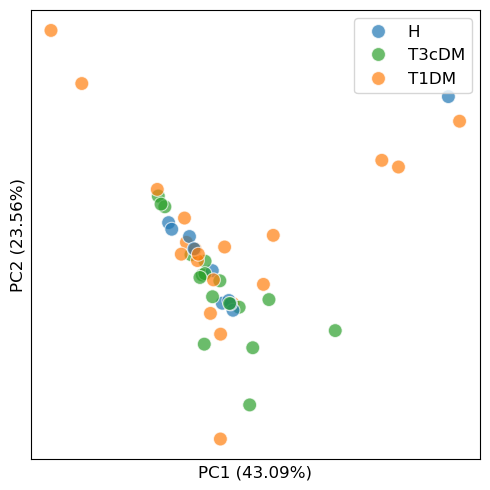

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Rename Type categories
pca_df["Type"] = pca_df["Type"].replace({
    "K": "H",
    "PDM": "T3cDM",
    "DM": "T1DM"
})

# Step 2: Update palette to match new labels
custom_palette = {
    "H": "#1f77b4",      # Formerly "K"
    "T1DM": "#ff7f0e",   # Formerly "DM"
    "T3cDM": "#2ca02c",  # Formerly "PDM"
}

# Step 3: Plot
plt.figure(figsize=(5, 5))
sns.scatterplot(
    data=pca_df,
    x=pca_df.columns[0],
    y=pca_df.columns[1],
    hue="Type",
    palette=custom_palette,
    alpha=0.7,
    s=100,
)
plt.xticks([])
plt.yticks([])

plt.xlabel(pca_df.columns[0], fontsize=12)
plt.ylabel(pca_df.columns[1], fontsize=12)
plt.title("")
plt.legend(title="", fontsize=12)
plt.tight_layout()
#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/pca.svg")
#plt.savefig("/data/scratch/kvalem/projects/2024/diabetes_microbe/05-results/figures/pca.png")
plt.show()
